In [1]:
import pandas as pd
import requests
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold, StratifiedKFold
import time 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sb

In [2]:
def get_user_animelist(username: str, client_id: str):
    # Loads list of anime from MAL for a given user
    url = f'https://api.myanimelist.net/v2/users/{username}/animelist?limit=500'
    headers = {
        'X-MAL-CLIENT-ID': client_id
    }
    params = {
        'fields': 'id, title, list_status{score,status}, start_season{year}, mean, genres, popularity, media_type, rating, num_episodes, studios, num_list_users,favorites'
    }

    all_data = []
    next_page = url

    while next_page:
        response = requests.get(next_page, headers=headers, params=params if next_page == url else None)
        if response.status_code != 200:
            raise ValueError(f"Error with API request: {response.status_code} - {response.text}")

        data = response.json()
        all_data.extend(data['data'])
        next_page = data.get("paging", {}).get("next")

        print(f"Loaded {len(all_data)} anime...")

    return all_data

In [3]:
def to_dataframe(all_data):
    rows = []
    for item in all_data:
        anime = item['node']
        score = item.get('list_status', {}).get('score')
        status = item.get('list_status', {}).get('status')
        # num_episodes_watched = item.get('list_status', {}).get('num_episodes_watched')
        year = item.get('node', {}).get('start_season', {}).get('year')
        rows.append({
            "id": anime['id'],
            "title": anime['title'],
            "mean": anime.get('mean'),
            "genres": [g['name'] for g in anime.get('genres', [])],
            "studios": [s['name'] for s in anime.get('studios', [])],
            "rating": anime.get('rating'),
            "year": year,
            "type": anime.get('media_type'),
            "popularity": anime.get('popularity'),
            "score": score,
            "status": status,
            "members": anime['num_list_users'],
            "num_episodes": anime['num_episodes'],
        })
    
    df = pd.DataFrame(rows)
    df['studios'] = df['studios'].str.join(", ")
    df['genres'] = df['genres'].str.join(", ")

    return df

In [4]:
def calculate_genre_affinity_simple(df_train):
    genre_cols = [col for col in df_train.columns if col.startswith('Genre_')]
    genre_affinity = {}
    
    overall_mean = df_train['score'].mean()
    
    for genre_col in genre_cols:
        genre_name = genre_col.replace('Genre_', '')
        mask = df_train[genre_col] == 1
        
        if mask.sum() >= 5:
            genre_affinity[genre_name] = df_train[mask]['score'].mean()
        else:
            genre_affinity[genre_name] = overall_mean
    
    return genre_affinity

In [5]:
def calculate_studio_mean(df_train):
    studios_columns = [col for col in df_train.columns if col.startswith('Studios_')]
    studio_mean = {}
    overall_mean = df_train['score'].mean()
    for studio_column in studios_columns:
        studio_name = studio_column.replace('Studios_', '')
        mask = df_train[studio_column] == 1
        
        if mask.sum() >= 3:
            studio_scores = df_train[mask]['score']
            mean_score = studio_scores.mean()
            studio_mean[studio_name] = mean_score
        else:
            studio_mean[studio_name] = overall_mean
            
    return studio_mean

In [6]:
def classify_3_classes(score):
    if score <= 5:
        return 0
    elif score <= 7:
        return 1
    else:
        return 2

In [7]:
import configparser

config = configparser.ConfigParser()
config.read('../config.ini')
USER_NAME = config.get('USER','USER_NAME').strip()
CLIENT_ID = config.get('USER','CLIENT_ID').strip()

In [8]:
data = get_user_animelist(USER_NAME, CLIENT_ID)

Loaded 500 anime...
Loaded 1000 anime...
Loaded 1500 anime...
Loaded 2000 anime...
Loaded 2500 anime...
Loaded 3000 anime...
Loaded 3500 anime...
Loaded 4000 anime...
Loaded 4500 anime...
Loaded 5000 anime...
Loaded 5059 anime...


In [9]:
df = to_dataframe(data)

In [10]:
df['score_class'] = df['score'].apply(classify_3_classes)

In [11]:
df["studios"].replace(to_replace="", value="Unknown", inplace=True)
df["genres"].replace(to_replace="", value="Unknown", inplace=True)
df = df.dropna(subset=['score'])

C:\Users\dobre\AppData\Local\Temp\ipykernel_18300\87429005.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["studios"].replace(to_replace="", value="Unknown", inplace=True)
C:\Users\dobre\AppData\Local\Temp\ipykernel_18300\87429005.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [12]:
display(df["score"].value_counts().head(11))

score
0     1333
5      793
7      757
6      574
8      517
4      434
3      350
9      151
2      114
10      25
1       11
Name: count, dtype: int64

In [13]:
df.drop(columns=['title', 'id'], inplace=True)

In [14]:
df = df[df['score'] > 0].copy()
    
df['mean'] = df['mean'].fillna(df.groupby('type')['mean'].transform('median'))
    
categorical_cols = ['type', 'rating', 'status']
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

In [15]:
df['year'] = df['year'].fillna(df['year'].mode()[0])
df['num_episodes'] = df['num_episodes'].fillna(df['num_episodes'].mode()[0])

In [16]:
df['popularity'] = df['popularity'].fillna(df['popularity'].median())

In [17]:
df['anime_age'] = 2025 - df['year']
df['anime_age'] = df['anime_age'].astype(int)
df.drop(columns=['year'], inplace=True)

In [18]:
df['log_members'] = np.log1p(df['members'])
df.drop(columns=['members'], inplace=True)

In [19]:
# Get dummy variables for each unique genre
genre_dummies = (
    df['genres']
    .str.split(', ', expand=True) 
    .stack()       
    .str.get_dummies()         
    .groupby(level=0)         
    .sum()                    
    .add_prefix('Genre_')  
)

In [20]:
df = pd.concat([df, genre_dummies], axis=1)

In [21]:
genre_columns = [col for col in df.columns if col.startswith('Genre_')]

genre_counts = df[genre_columns].sum().sort_values(ascending=False)
print(genre_counts)

Genre_Action         1480
Genre_Comedy         1336
Genre_Fantasy         996
Genre_School          918
Genre_Romance         871
                     ... 
Genre_Educational       6
Genre_Hentai            2
Genre_Boys Love         2
Genre_Erotica           2
Genre_Unknown           1
Length: 79, dtype: int64


In [22]:
genre_columns = [col for col in df.columns if col.startswith('Genre_')]

genre_counts = df[genre_columns].sum().sort_values(ascending=False)
total_anime = len(df)

min_count = max(5, int(total_anime * 0.01))
frequent_genres= genre_counts[genre_counts >= min_count].index.tolist()

print(f"studio_counts: {len(genre_counts)}")
print(f"Studios with >= {min_count} anime: {len(frequent_genres)}")

rare_genre_columns = [col for col in genre_columns if col not in frequent_genres]
df['Genre_Other'] = df[rare_genre_columns].max(axis=1) 

df.drop(columns=rare_genre_columns, inplace=True)

studio_counts: 79
Studios with >= 37 anime: 58


In [23]:
df.drop(columns=['genres'], inplace=True)

In [24]:
type_dummies = pd.get_dummies(df['type'], prefix='Type')
df = pd.concat([df, type_dummies], axis=1)
df.drop(columns=['type'], inplace=True)

In [25]:
studio_dummies = (
    df['studios']
    .str.split(', ', expand=True) 
    .stack()       
    .str.get_dummies()         
    .groupby(level=0)         
    .sum()                    
    .add_prefix('Studios_')  
)
df = pd.concat([df, studio_dummies], axis=1)

In [26]:
studio_columns = [col for col in df.columns if col.startswith('Studios_')]

studio_counts = df[studio_columns].sum().sort_values(ascending=False)
print(studio_counts)

Studios_J.C.Staff               191
Studios_A-1 Pictures            147
Studios_Madhouse                136
Studios_Production I.G          122
Studios_Studio Deen             118
                               ... 
Studios_Karaku                    1
Studios_Studio Gram               1
Studios_KeyEast                   1
Studios_Studio Gazelle            1
Studios_Next Media Animation      1
Length: 330, dtype: int64


In [27]:
studio_columns = [col for col in df.columns if col.startswith('Studios_')]

studio_counts = df[studio_columns].sum().sort_values(ascending=False)
total_anime = len(df)

min_count = max(10, int(total_anime * 0.01))
frequent_studios = studio_counts[studio_counts >= min_count].index.tolist()

print(f"studio_counts: {len(studio_counts)}")
print(f"Studios with >= {min_count} anime: {len(frequent_studios)}")

rare_studio_columns = [col for col in studio_columns if col not in frequent_studios]
df['Studio_Other'] = df[rare_studio_columns].max(axis=1) 

df.drop(columns=rare_studio_columns, inplace=True)

studio_counts: 330
Studios with >= 37 anime: 29


In [28]:
df.drop(columns=['studios'], inplace=True)

In [29]:
rating_dummies = pd.get_dummies(df['rating'], prefix='Rating')
df = pd.concat([df, rating_dummies], axis=1)
df.drop(columns=['rating'], inplace=True)

In [30]:
status_dummies = pd.get_dummies(df['status'], prefix='Status')
df = pd.concat([df, status_dummies], axis=1)
df.drop(columns=['status'], inplace=True)

In [31]:
df.drop(columns=['Status_completed'], inplace=True)
df.drop(columns=['Type_tv'], inplace=True)
df.drop(columns=['Rating_pg_13'], inplace=True)

In [32]:
bool_cols = df.select_dtypes('bool').columns

df[bool_cols] = df[bool_cols].astype(int)

In [33]:
# df.drop(columns=['Genre_Unknown'], inplace=True)

In [34]:
corr_with_score = df.corr()['score']
high_corr_cols = corr_with_score[np.abs(corr_with_score) > 0.65].index
high_corr_cols = high_corr_cols.drop(['score','score_class'])
print(high_corr_cols)

Index(['mean'], dtype='object')


In [35]:
df.drop(columns=high_corr_cols, inplace=True)

In [36]:
df['num_episodes'] = np.log1p(df['num_episodes'])

In [37]:
df.drop(columns=['popularity'], inplace=True)
# df.drop(columns=['log_members'], inplace=True)

In [38]:
X = df.drop(columns=['score', 'score_class'])
y = df['score_class']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [40]:
genre_affinity = calculate_genre_affinity_simple(X_train.join(df['score']))

affinity_features_train = pd.DataFrame({
    f"affinity_{genre}": X_train[f"Genre_{genre}"] * affinity
    for genre, affinity in genre_affinity.items()
}, index=X_train.index)

affinity_features_test = pd.DataFrame({
    f"affinity_{genre}": X_test[f"Genre_{genre}"] * affinity
    for genre, affinity in genre_affinity.items()
}, index=X_test.index)

X_train = pd.concat([X_train, affinity_features_train], axis=1)
X_test = pd.concat([X_test, affinity_features_test], axis=1)

In [41]:
X_train = X_train.drop(columns=[col for col in X_train.columns if col.startswith("Genre_")])
X_test = X_test.drop(columns=[col for col in X_test.columns if col.startswith("Genre_")])

In [42]:
# studios_affinity = calculate_studio_mean(X_train.join(df['score']))
# 
# affinity_features_train = pd.DataFrame({
#     f"affinity_{studio}": X_train[f"Studios_{studio}"] * affinity
#     for studio, affinity in studios_affinity.items()
# }, index=X_train.index)
# 
# affinity_features_test = pd.DataFrame({
#     f"affinity_{studio}": X_test[f"Studios_{studio}"] * affinity
#     for studio, affinity in studios_affinity.items()
# }, index=X_test.index)
# 
# X_train = pd.concat([X_train, affinity_features_train], axis=1)
# X_test = pd.concat([X_test, affinity_features_test], axis=1)

In [43]:
# X_train = X_train.drop(columns=[col for col in X_train.columns if col.startswith("Studios_")])
# X_test = X_test.drop(columns=[col for col in X_test.columns if col.startswith("Studios_")])

In [44]:
X_train.sample(10)

,num_episodes,anime_age,log_members,Type_cm,Type_movie,Type_music,Type_ona,Type_ova,Type_pv,Type_special,...,affinity_Supernatural,affinity_Survival,affinity_Suspense,affinity_Team Sports,affinity_Time Travel,affinity_Urban Fantasy,affinity_Vampire,affinity_Video Game,affinity_Workplace,affinity_Other
3629,2.564949,2,11.024399,0,0,0,0,0,0,0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,6.189781
24,3.135494,8,12.970058,0,0,0,0,0,0,0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,6.189781
3112,1.609438,13,13.270452,0,0,0,0,0,0,0,...,6.147945,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4799,0.693147,11,11.465215,0,0,0,0,1,0,0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4766,2.564949,16,9.334591,0,0,0,0,0,0,0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
540,2.944439,6,12.391115,0,0,0,0,0,0,0,...,6.147945,0.0,6.37234,0.0,0.0,0.0,0.0,0.0,0.0,6.189781
2313,2.564949,12,12.150370,0,0,0,0,0,0,0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3668,1.945910,11,9.909619,0,0,0,0,0,0,1,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2399,2.639057,1,10.845290,0,0,0,0,0,0,0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,6.0,0.0,0.000000
967,2.564949,3,10.934053,0,0,0,0,0,0,0,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [45]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [46]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

In [47]:
print(class_weight_dict)

{0: 0.7298554984080333, 1: 0.9327073552425665, 2: 1.7930204572803852}


In [120]:
model = CatBoostClassifier(early_stopping_rounds=50,random_state=42, verbose=0)

In [121]:
params = {
    'iterations': [200, 300, 400],
    'depth': [3, 4, 6],
    'learning_rate': [0.01, 0.03, 0.05],
    'l2_leaf_reg': [3, 5, 7],
    'random_strength': [1.0, 1.5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)
grid = GridSearchCV(
    estimator=model,
    param_grid=params,
    scoring='f1_macro',
    cv=cv,
    refit=True,
    n_jobs=-1,
    verbose=2,
    return_train_score=True  
)

In [123]:
grid.fit(
    X_train, y_train
)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=24, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x000001CA43A3DE20>,
             n_jobs=-1,
             param_grid={'depth': [3, 4, 6], 'iterations': [200, 300, 400],
                         'l2_leaf_reg': [3, 5, 7],
                         'learning_rate': [0.01, 0.03, 0.05],
                         'random_strength': [1.0, 1.5]},
             return_train_score=True, scoring='f1_macro', verbose=2)

In [124]:
results = pd.DataFrame(grid.cv_results_)
results = results.sort_values(by="mean_test_score", ascending=False)
print(results[[
    "param_depth",
    "param_iterations",
    "param_learning_rate",
    "param_l2_leaf_reg",
    "param_random_strength",
    "mean_test_score",
    "std_test_score"
]].head(10))

     param_depth  param_iterations  param_learning_rate  param_l2_leaf_reg  \
95             4               400                 0.05                  3   
148            6               400                 0.05                  3   
101            4               400                 0.05                  5   
149            6               400                 0.05                  3   
94             4               400                 0.05                  3   
161            6               400                 0.05                  7   
154            6               400                 0.05                  5   
160            6               400                 0.05                  7   
155            6               400                 0.05                  5   
143            6               300                 0.05                  7   

     param_random_strength  mean_test_score  std_test_score  
95                     1.5         0.606050        0.017728  
148              

In [56]:
model = CatBoostClassifier(
    depth=4,
    l2_leaf_reg=3,
    eval_metric='MultiClass', 
    class_weights=class_weight_dict, 
    early_stopping_rounds=50,
    random_state=42,
    verbose=0
)

In [57]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

model.fit(
    X_tr, y_tr,
    eval_set=(X_val, y_val),
    use_best_model=True
)

In [58]:
y_pred = model.predict(X_test)

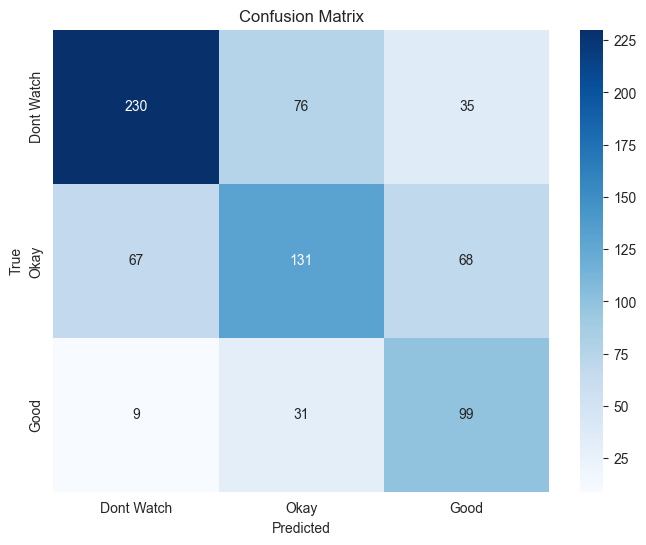

              precision    recall  f1-score   support

  Dont Watch       0.75      0.67      0.71       341
        Okay       0.55      0.49      0.52       266
        Good       0.49      0.71      0.58       139

    accuracy                           0.62       746
   macro avg       0.60      0.63      0.60       746
weighted avg       0.63      0.62      0.62       746



In [60]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dont Watch', 'Okay', 'Good'],
            yticklabels=['Dont Watch', 'Okay', 'Good'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Детальный отчет
print(classification_report(y_test, y_pred, 
                          target_names=['Dont Watch', 'Okay', 'Good']))